In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
train_dir = './train_withoout_callback'

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    validation_split=0.2) #수평방향 뒤집기

Using TensorFlow backend.


In [4]:
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(224,224),
        batch_size=32,
        subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(224,224),
    batch_size=32,
    subset='validation') # set as validation data

Found 1372 images belonging to 4 classes.
Found 340 images belonging to 4 classes.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='png_VGG16_finetuning.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [12]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=5,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/5
43/42 [==============================] - 19s 439ms/step - loss: 1.3883 - acc: 0.2821 - auc: 0.5324 - precision: 0.1938 - recall: 3.8156e-04 - f1score: 0.1013 - val_loss: 1.3951 - val_acc: 0.3118 - val_auc: 0.5486 - val_precision: 0.6667 - val_recall: 0.0013 - val_f1score: 0.1032
Epoch 2/5
43/42 [==============================] - 16s 367ms/step - loss: 1.3351 - acc: 0.3622 - auc: 0.5658 - precision: 0.7304 - recall: 0.0014 - f1score: 0.1055 - val_loss: 1.3526 - val_acc: 0.3265 - val_auc: 0.5850 - val_precision: 0.7415 - val_recall: 0.0023 - val_f1score: 0.1047
Epoch 3/5
43/42 [==============================] - 17s 389ms/step - loss: 1.3094 - acc: 0.3929 - auc: 0.5973 - precision: 0.7812 - recall: 0.0043 - f1score: 0.1077 - val_loss: 1.3038 - val_acc: 0.3882 - val_auc: 0.6094 - val_precision: 0.7734 - val_recall: 0.0067 - val_f1score: 0.1065
Epoch 4/5
43/42 [==============================] - 17s 392ms/step - loss: 1.2869 - acc: 0.4067 - auc: 0.6181 - precision: 0.7327 - recall:

In [13]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [14]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [15]:
history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=10,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/10
43/42 [==============================] - 17s 403ms/step - loss: 1.1960 - acc: 0.4461 - auc_1: 0.7238 - precision_1: 0.6244 - recall_1: 0.1227 - f1score: 0.1215 - val_loss: 1.1420 - val_acc: 0.4441 - val_auc_1: 0.7307 - val_precision_1: 0.6181 - val_recall_1: 0.1220 - val_f1score: 0.1218
Epoch 2/10
43/42 [==============================] - 16s 379ms/step - loss: 1.0910 - acc: 0.4862 - auc_1: 0.7464 - precision_1: 0.6158 - recall_1: 0.1366 - f1score: 0.1313 - val_loss: 1.1229 - val_acc: 0.4353 - val_auc_1: 0.7573 - val_precision_1: 0.6134 - val_recall_1: 0.1595 - val_f1score: 0.1301
Epoch 3/10
43/42 [==============================] - 16s 374ms/step - loss: 1.0086 - acc: 0.5292 - auc_1: 0.7676 - precision_1: 0.6234 - recall_1: 0.1801 - f1score: 0.1397 - val_loss: 1.0359 - val_acc: 0.5324 - val_auc_1: 0.7761 - val_precision_1: 0.6275 - val_recall_1: 0.1968 - val_f1score: 0.1363
Epoch 4/10
43/42 [==============================] - 16s 375ms/step - loss: 0.9837 - acc: 0.5459 - auc_1

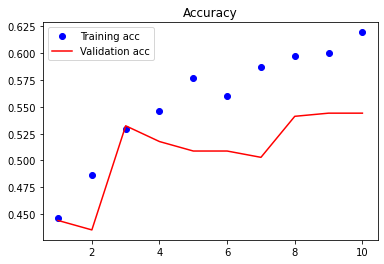

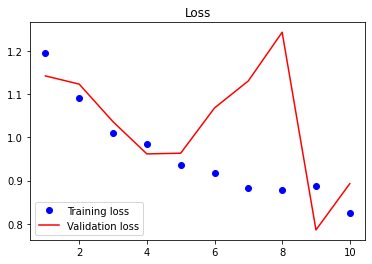

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [17]:
for layer in additional_model.layers:
    layer.trainable=True

In [18]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-6),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples /32,
      epochs=37,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples/32,
      callbacks=[checkpoint])

Epoch 1/37
43/42 [==============================] - 17s 404ms/step - loss: 0.7908 - acc: 0.6531 - auc: 0.8901 - precision_2: 0.7301 - recall_2: 0.5354 - f1score: 0.1631 - val_loss: 0.7878 - val_acc: 0.5471 - val_auc: 0.8840 - val_precision_2: 0.7136 - val_recall_2: 0.5217 - val_f1score: 0.1504
Epoch 2/37
43/42 [==============================] - 16s 375ms/step - loss: 0.7750 - acc: 0.6603 - auc: 0.8838 - precision_2: 0.7121 - recall_2: 0.5184 - f1score: 0.1645 - val_loss: 0.7433 - val_acc: 0.5500 - val_auc: 0.8840 - val_precision_2: 0.7117 - val_recall_2: 0.5223 - val_f1score: 0.1522
Epoch 3/37
43/42 [==============================] - 16s 374ms/step - loss: 0.7790 - acc: 0.6574 - auc: 0.8843 - precision_2: 0.7103 - recall_2: 0.5225 - f1score: 0.1647 - val_loss: 0.9508 - val_acc: 0.5588 - val_auc: 0.8839 - val_precision_2: 0.7099 - val_recall_2: 0.5232 - val_f1score: 0.1494
Epoch 4/37
43/42 [==============================] - 16s 378ms/step - loss: 0.7672 - acc: 0.6443 - auc: 0.8826 - pre

Epoch 29/37
43/42 [==============================] - 16s 380ms/step - loss: 0.7024 - acc: 0.6968 - auc: 0.8912 - precision_2: 0.7102 - recall_2: 0.5568 - f1score: 0.1731 - val_loss: 0.7616 - val_acc: 0.5853 - val_auc: 0.8913 - val_precision_2: 0.7101 - val_recall_2: 0.5574 - val_f1score: 0.1566
Epoch 30/37
43/42 [==============================] - 16s 379ms/step - loss: 0.7061 - acc: 0.6931 - auc: 0.8915 - precision_2: 0.7100 - recall_2: 0.5578 - f1score: 0.1732 - val_loss: 0.7913 - val_acc: 0.5765 - val_auc: 0.8916 - val_precision_2: 0.7100 - val_recall_2: 0.5583 - val_f1score: 0.1568
Epoch 31/37
43/42 [==============================] - 16s 379ms/step - loss: 0.7118 - acc: 0.6917 - auc: 0.8918 - precision_2: 0.7102 - recall_2: 0.5587 - f1score: 0.1728 - val_loss: 0.8304 - val_acc: 0.5735 - val_auc: 0.8919 - val_precision_2: 0.7103 - val_recall_2: 0.5593 - val_f1score: 0.1565
Epoch 32/37
43/42 [==============================] - 16s 379ms/step - loss: 0.6950 - acc: 0.6997 - auc: 0.8920 -

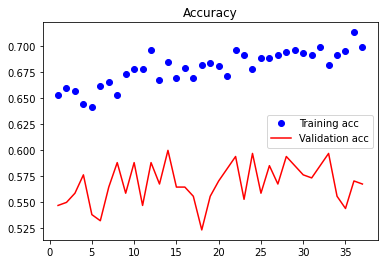

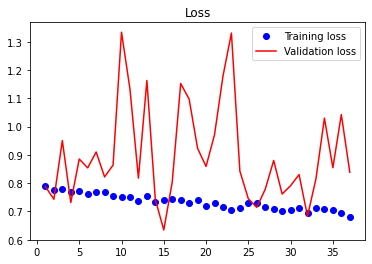

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [20]:
_loss, _acc, _auc, _precision, _recall, _f1score =  additional_model.evaluate_generator(validation_generator, steps=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

loss: 1.104, accuracy: 0.580, auc: 0.893, precision: 0.711, recall: 0.564, f1score: 0.158


In [21]:
from keras.models import Model, load_model

new_model = models.load_model('png_VGG16_finetuning.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [23]:
test_dir='./test_without_callback'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32)

Found 571 images belonging to 4 classes.


In [25]:
_loss, _acc, _auc, _precision, _recall, _f1score =new_model.evaluate_generator(test_generator, steps=test_generator.samples/32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

loss: 0.901, accuracy: 0.625, auc: 0.868, precision: 0.654, recall: 0.542, f1score: 0.164
